### Setup

In [2]:
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
np.random.seed(42)

### 下载 MNIST 数据集

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
mnist["url"]

'https://www.openml.org/d/554'

In [5]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


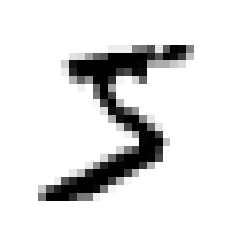

In [6]:
# plot a instance
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
# 将 y 从字符串转换成 数字

y = y.astype(np.uint8)
y[0]

5

### 构造训练集 测试集
MNIST 数据集已经打算顺序，并且分成了训练集和测试集

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 训练一个二分类器
预测为5和不是5的情况

In [10]:
# 修改label 使其数据只是 True or False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print(y_train_5[:5])
print(y_test_5[:5])

[ True False False False False]
[False False False False False]


In [11]:
# 训练一个模型
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# 使用训练好的模型做预测
sgd_clf.predict([some_digit])

array([ True])

### 对性能的评估
#### 使用交叉验证测量准确性(Accuracy)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96355, 0.93795, 0.95615])

上面显示准确性挺高的，但是是真实的，下面做一个实验,预测所有的都不是5， 也能得到超过>90%的准确率

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # 直接返回 len(X)行 x 1列的全零矩阵

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 混淆矩阵 Confusion Matrix
测量一个分类器的性能的比较好的方式是混淆矩阵  
Each row in a confusion matrix represents an actual class, while each column represents a predicted class   
https://baijiahao.baidu.com/s?id=1619821729031070174&wfr=spider&for=pc  
![image](https://ss1.baidu.com/6ONXsjip0QIZ8tyhnq/it/u=4047180211,1726718906&fm=173&app=49&f=JPEG?w=442&h=192&s=B51EA57F1B604C0356F55C7A0300C070)

In [15]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict 返回基于测试折的预测值
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
y_train_pred_test = sgd_clf.predict(X_train)
y_train_pred_test

array([ True, False, False, ...,  True, False, False])

cross_val_predict 和 cross_val_score的使用方法是一样的，但是它返回的是一个使用交叉验证以后的输出值，而不是评分标准。它的运行过程是这样的，使用交叉验证的方法来计算出每次划分为测试集部分数据的值，知道所有的数据都有了预测值。假如数据划分为[1,2,3,4,5]份，它先用[1,2,3,4]训练模型，计算出来第5份的目标值，然后用[1,2,3,5]计算出第4份的目标值，直到都结束为止。

In [17]:
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53057,  1522],
       [ 1325,  4096]])

In [18]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 准确率 
真正是True的instance占预测是True 的比率
![image](https://github.com/it-ebooks/hands-on-ml-zh/raw/d6963c5048a1d4b1da9e741c625f7cc2a1400235/images/tex-96d2dbcd621a2da7cff58eaed68d87c2.gif)

### 召回率（recall）
也叫做敏感度（sensitivity）或者真正例率（true positive rate， TPR）。这是正例被分类器正确探测出的比率。
![image](https://github.com/it-ebooks/hands-on-ml-zh/raw/d6963c5048a1d4b1da9e741c625f7cc2a1400235/images/tex-9fc030ab004eb3b12a815227ce62da52.gif)

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7290850836596654
0.7555801512636044


将准确率和召回率可以一起使用，合并成一个指标 F1 值， 这个可以用来比较两个分类器的优劣。F1 值是准确率和召回率的调和平均。普通的平均值平等地看待所有的值，而调和平均会给小的值更大的权重。所以，要想分类器得到一个高的 F1 值，需要召回率和准确率同时高。
![image](https://github.com/it-ebooks/hands-on-ml-zh/raw/d6963c5048a1d4b1da9e741c625f7cc2a1400235/images/tex-dba6270fb2a2c1da75f72bdd3137f6ec.gif)

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7420962043663375

### Precision/Recall Trade-off
将准确率和召回率一般情况下不能同时达到最大，这时候我们需要根据自己的需求有一个权衡   
例如 SGDClassifier 对于每一个实例，会使用决策函数（decision function）去计算一个分数。并且分类器内部有一个阈值（threshold）,超过阈值预测为正类，否则为父类。  
下面图片选择不同阈值，会得到不同的准确率和召回率。
![image](https://github.com/it-ebooks/hands-on-ml-zh/raw/d6963c5048a1d4b1da9e741c625f7cc2a1400235/images/chapter_3/chapter3.3-3.jpeg)

In [21]:
# 我们不能手动的设置这个阈值，但是我们可以使用 decision_function() 得到每一个 instance 的分数
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2412.53175101]
[ True]
[False]


In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
print(precisions.shape)
print(precisions[:-1].shape) # -1 去掉一个数据
print(recalls.shape)
print(thresholds.shape)

(59420,)
(59419,)
(59420,)
(59419,)


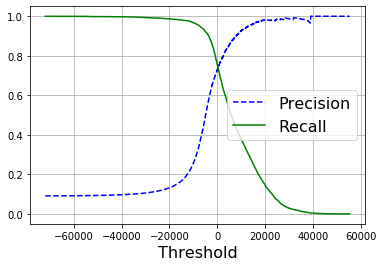

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)  
    plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

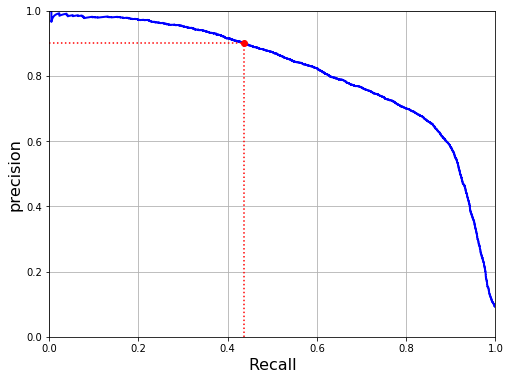

In [25]:
def plot_precision_vs_recall(precisions, recalls): 
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:") # 这个数字是下面计算出来的 
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [26]:
# >=90 准确率阈值
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

y_train_pred_90 = (y_scores > threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

7816.1555236825225
0.9003802281368821
0.4368197749492714


### The ROC Curve
ROC 曲线是真正例率（true positive rate，另一个名字叫做召回率）对假正例率（false positive rate, FPR）的曲线。 
ROC的全称是Receiver Operating Characteristic Curve，中文名字叫“受试者工作特征曲线”
FPR 是反例被错误分成正例的比率。它等于 1 减去真反例率（true negative rate， TNR）。TNR是反例被正确分类的比率。TNR也叫做特异性。所以 ROC 曲线画出召回率对（1 减特异性）的曲线。 
https://www.jianshu.com/p/2ca96fce7e81

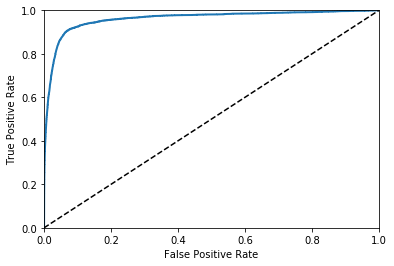

In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the **area under the curve (AUC)**. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.   
Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).

In [28]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9611778893101814


In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

/Users/xiangyue/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/xiangyue/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/xiangyue/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
y_probas_forest

array([[0.1, 0.9],
       [1. , 0. ],
       [0.9, 0.1],
       ...,
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ]])

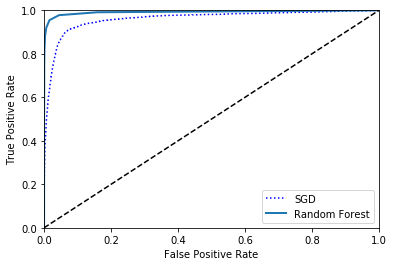

In [31]:
import pandas as pd
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# RandomForestClassifier ROC 优于 SGDClassifier ROC

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

### 多类分类器
#### one-versus-the-rest (OvR) strategy (also called one-versus-all).
例如上面的分类1到9，训练10个分类器，然后预测时候计算所有分类器给的分数，取分数高的。
#### one-versus-one (OvO) strategy
例如上面的分类1到9，需要训练1v2, 1v3, 1v4 ... 2v3, 2v4 ... 8v9 这些分类器。分类器个数 *N X (N -1) / 2*.  

对比上面的优势是每次训练只需要两个类别就可以了，有些分类器如果数据量大会性能下降很快，比较适合这种方式。

In [33]:
# sklearn 内部会根据算法决定使用什么策略
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # not y_train_5 OvO策略
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores  

array([[ 2.92492871,  7.02307409,  3.93648529,  0.90117363,  5.96945908,
         9.5       ,  1.90718593,  8.02755089, -0.13202708,  4.94216947]])

In [35]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)  # 存储着每个分类器的目标值
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


使用 OneVsOneClassifier 或者 OneVsRestClassifier 可以指定算法使用什么策略去训练分类器

In [36]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [37]:
len(ovr_clf.estimators_)

10

In [38]:
# SGDClassifier 不需要使用 OvR or OvO 策略，它是直接进行训练
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
print(sgd_clf.predict([some_digit]))
print(sgd_clf.decision_function([some_digit]))

[5]
[[-15955.22627845 -38080.96296175 -13326.66694897    573.52692379
  -17680.6846644    2412.53175101 -25526.86498156 -12290.15704709
   -7946.05205023 -10631.35888549]]


In [40]:
# 使用交叉验证，验证准确度
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8489802 , 0.87129356, 0.86988048])

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") # 通过缩放获取更高的正确率

array([0.89707059, 0.8960948 , 0.90693604])

### 误差分析

In [42]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5578,    0,   22,    7,    8,   45,   35,    5,  222,    1],
       [   0, 6410,   35,   26,    4,   44,    4,    8,  198,   13],
       [  28,   27, 5232,  100,   74,   27,   68,   37,  354,   11],
       [  23,   18,  115, 5254,    2,  209,   26,   38,  373,   73],
       [  11,   14,   45,   12, 5219,   11,   33,   26,  299,  172],
       [  26,   16,   31,  173,   54, 4484,   76,   14,  482,   65],
       [  31,   17,   45,    2,   42,   98, 5556,    3,  123,    1],
       [  20,   10,   53,   27,   50,   13,    3, 5696,  173,  220],
       [  17,   64,   47,   91,    3,  125,   24,   11, 5421,   48],
       [  24,   18,   29,   67,  116,   39,    1,  174,  329, 5152]])

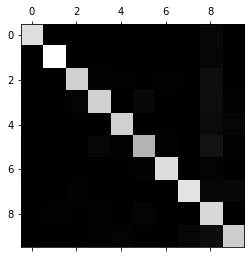

In [43]:
# 使用图片来展示混淆矩阵
plt.matshow(conf_mx, cmap=plt.cm.gray) # 越亮数目越大
plt.show()

[[9.41752490e-01 0.00000000e+00 3.71433395e-03 1.18183353e-03
  1.35066689e-03 7.59750127e-03 5.90916765e-03 8.44166807e-04
  3.74810062e-02 1.68833361e-04]
 [0.00000000e+00 9.50756452e-01 5.19133788e-03 3.85642243e-03
  5.93295758e-04 6.52625334e-03 5.93295758e-04 1.18659152e-03
  2.93681400e-02 1.92821121e-03]]


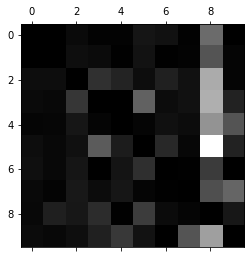

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True) # 计算每一行的和
# print(row_sums)
# print(conf_mx[0, :].sum())
norm_conf_mx = conf_mx / row_sums # 每一行被错误预测的比例
print(norm_conf_mx[[0, 1], :])

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Multilabel Classification

In [45]:
from sklearn.neighbors import KNeighborsClassifier
# 这个地方只是使用前1000的数据进行训练，如果使用全部数据集会比较大，训练时间会很久

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train[:1000], y_multilabel[:1000])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [46]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [47]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train[:1000], y_multilabel[:1000], cv=3)
f1_score(y_multilabel[:1000], y_train_knn_pred, average="macro")

0.8997065962087929

### multioutput–multiclass classification

In [48]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

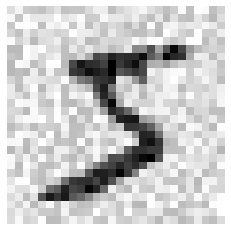

In [49]:
some_digit = X_train_mod[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

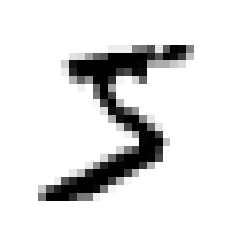

In [50]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_digit])

some_digit_image = clean_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

## 练习
### 1

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5]
}]
knn_clf = KNeighborsClassifier() 
grid_search = GridSearchCV(knn_clf, param_grid, cv=1, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

### 2 Data Augmentation 数据增强

In [ ]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131) # 表示将整个图像窗口分为1行3列, 当前位置为1.
plt.title('Original', fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation='nearest', cmap='Greys')
plt.subplot(132) 
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

### 3